In [39]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [41]:
dataset = Planetoid(root=data_dir, name='Cora')
all_data = dataset[0]

In [42]:
print(f'Number of nodes: {all_data.num_nodes}')

Number of nodes: 2708


In [43]:
# train_x = all_data.x[all_data.train_mask]
# train_y = all_data.y[all_data.train_mask]

# edge_index = all_data.edge_index
# print(edge_index.shape)


In [65]:
#create a dictionary of node and its neighbors

neighbors = {}

for i in range(all_data.edge_index.shape[1]):
    source_node = all_data.edge_index[0][i].item()
    target_node = all_data.edge_index[1][i].item()
    
    if source_node not in neighbors:
        neighbors[source_node] = [target_node]
    else:
        neighbors[source_node].append(target_node)
        
        

In [32]:
# #cdata

# #create cora_graph from train_x and train_y and edge_index

# cora_graph = nx.Graph()
# #wherever the train_mask is true, add that node to the graph

# for i in range(len(all_data.train_mask)):
#     if all_data.train_mask[i] == True:
#         cora_graph.add_node(i)
        
# #add edges to the graph between the nodes in the graph if they are connected in the edge_index
# for node in cora_graph.nodes():
#     for neighbor in neighbors[node]:
#         if cora_graph.has_node(neighbor):
#             cora_graph.add_edge(node, neighbor)

In [45]:
#print all edges
all_data.edge_index.t().tolist()

#create a networkx graph
cora_graph = to_networkx(all_data, to_undirected=True)

In [46]:
#import client gml file called new_facebook_network.gml and convert to networkx graph
client_graph = nx.read_gml('new_facebook_network.gml')
#create a dictionary of each node and a list of its neighbors
client_neighbors = {}
for node in client_graph.nodes():
    client_neighbors[node] = list(client_graph.neighbors(node))
    


In [47]:
#select 100 nodes with the largest degree as nodes for each node in the client graph

#degree of each node
degree_dict = dict(cora_graph.degree(cora_graph.nodes()))
degree_dict
#sort the nodes according to their degree
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
sorted_degree

top_100_nodes = [x[0] for x in sorted_degree[:100]]
top_100_nodes

[1358,
 306,
 1701,
 1986,
 1810,
 1623,
 2034,
 88,
 1013,
 598,
 109,
 2045,
 1914,
 1072,
 1542,
 733,
 1224,
 1042,
 1169,
 1441,
 1483,
 95,
 415,
 1131,
 118,
 963,
 1413,
 1692,
 2182,
 436,
 507,
 1416,
 310,
 973,
 1103,
 1624,
 1628,
 1703,
 1765,
 2155,
 429,
 661,
 1257,
 1309,
 1725,
 2001,
 2394,
 525,
 687,
 1229,
 1742,
 1950,
 1973,
 350,
 1740,
 1894,
 2248,
 2367,
 2671,
 239,
 1015,
 1119,
 1505,
 1927,
 55,
 73,
 154,
 279,
 487,
 519,
 565,
 577,
 645,
 657,
 734,
 1655,
 1776,
 1966,
 2025,
 2130,
 2450,
 2464,
 94,
 218,
 236,
 364,
 441,
 454,
 505,
 748,
 756,
 1154,
 1317,
 2238,
 2359,
 2451,
 59,
 65,
 89,
 180]

In [48]:
client_to_subgraph = {}

client_neighbors.keys()

for i, c in enumerate(client_neighbors.keys()):
    client = c
    cora_node = top_100_nodes[i]
    
    #create empty graph
    client_to_subgraph[c] = nx.Graph()
    client_to_subgraph[c].add_node(cora_node)
    #add all neighbors of the top node to the graph
    client_to_subgraph[c].add_nodes_from(cora_graph.neighbors(cora_node))
    #add all edges connecting the top node and its neighbors
    client_to_subgraph[c].add_edges_from(cora_graph.edges(cora_node))
    #add all edges between the neighbors with double for loop
    for j in cora_graph.neighbors(cora_node):
        for k in cora_graph.neighbors(cora_node):
            if j != k:
                if(cora_graph.has_edge(j,k)):
                    client_to_subgraph[c].add_edge(j,k)
                

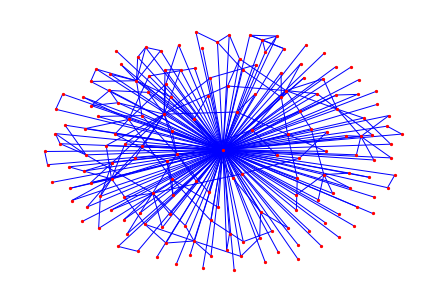

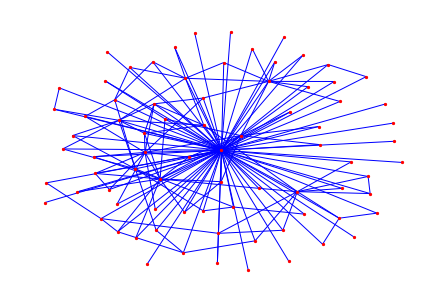

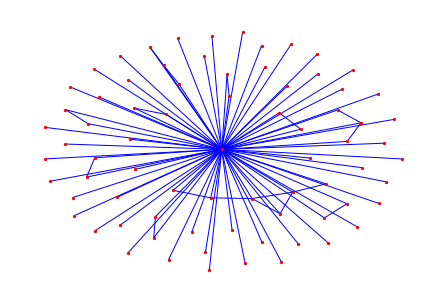

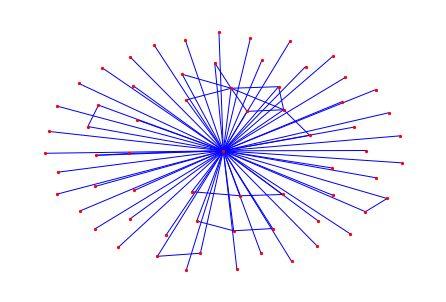

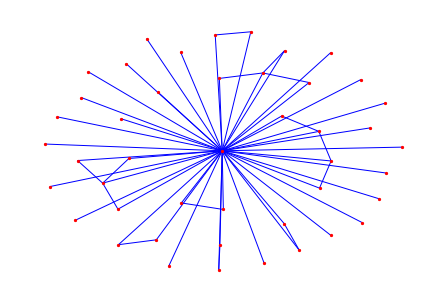

In [49]:
#draw five graphs
for i, c in enumerate(client_to_subgraph.keys()):
    nx.draw(client_to_subgraph[c], with_labels=False, node_size=5, node_color='r', edge_color='b')
    plt.show()
    if i == 4:
        break

In [50]:
#for each subgraph, calculate average degree, average path length, and degree distribution 
#degree distribution is the degree and the number of nodes with that degree
average_degree = {}
average_path_length = {}
degree_distribution = {}
number_of_nodes = {}
number_of_edges = {}

for i, c in enumerate(client_to_subgraph.keys()):
    number_of_nodes[c] = len(client_to_subgraph[c].nodes())
    number_of_edges[c] = len(client_to_subgraph[c].edges())
    average_degree[c] = sum(dict(client_to_subgraph[c].degree()).values())/len(client_to_subgraph[c].nodes())
    average_path_length[c] = nx.average_shortest_path_length(client_to_subgraph[c])
    degrees = dict(client_to_subgraph[c].degree()).values()
    degree_dict = {}
    for d in degrees:
        if d not in degree_dict:
            degree_dict[d] = 1
        else:
            degree_dict[d] += 1
    #sort dictionary by value in descending order
    sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
    degree_distribution[c] = sorted_degree
    

print(average_degree)
print(average_path_length)
print(degree_distribution)
print(number_of_nodes)
print(number_of_edges)

{'828': 3.8816568047337277, '713': 4.379746835443038, '705': 2.4266666666666667, '719': 2.484848484848485, '805': 2.577777777777778, '824': 2.744186046511628, '745': 2.4390243902439024, '747': 3.4054054054054053, '823': 2.1714285714285713, '694': 2.823529411764706, '830': 3.9393939393939394, '781': 3.8181818181818183, '697': 2.8125, '724': 3.4838709677419355, '827': 3.870967741935484, '688': 2.8, '853': 3.037037037037037, '834': 2.9166666666666665, '703': 3.5833333333333335, '695': 2.5, '784': 4.521739130434782, '815': 3.4545454545454546, '752': 3.4545454545454546, '728': 3.0, '820': 2.9, '842': 3.3, '800': 5.0, '819': 3.6, '774': 2.6, '726': 2.4210526315789473, '773': 4.2105263157894735, '766': 2.210526315789474, '829': 3.7777777777777777, '780': 2.0, '810': 3.2222222222222223, '696': 2.4444444444444446, '849': 3.111111111111111, '718': 3.5555555555555554, '754': 3.3333333333333335, '760': 2.6666666666666665, '739': 2.235294117647059, '787': 2.1176470588235294, '856': 4.58823529411764

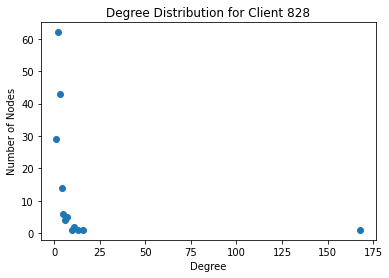

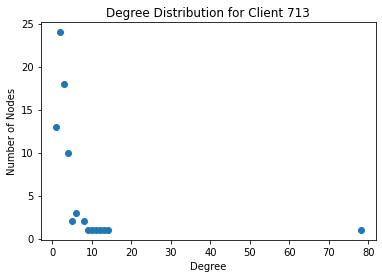

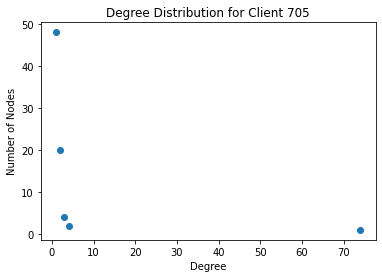

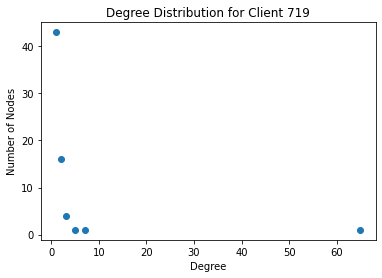

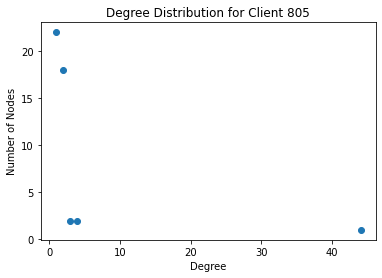

In [51]:
#plot degree distribution for 5 clients

for i, c in enumerate(client_to_subgraph.keys()):
    degrees = degree_distribution[c]
    x = [x[0] for x in degrees]
    y = [x[1] for x in degrees]
    plt.scatter(x,y)
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title('Degree Distribution for Client ' + str(c))
    plt.show()
    
    if i == 4:
        break

In [52]:
#100x100 matrix for each pair of client nodes, and the value is how many common nodes the subgraphs have

#initialize the matrix (dataframe so that we can label the rows and columns as the client nodes)
client_similarity = pd.DataFrame(index=client_neighbors.keys(), columns=client_neighbors.keys())
client_similarity = client_similarity.fillna(0)

#for each pair of client nodes, find the number of common nodes in their subgraphs
#divide by the number of nodes in the subgraph of the first client node to normalize

#go through each entry in the matrix
for i in client_similarity.index:
    for j in client_similarity.index:
        #nodes in the subgraph of the first client node
        nodes1 = client_to_subgraph[i].nodes()
        #nodes in the subgraph of the second client node
        nodes2 = client_to_subgraph[j].nodes()
        #find the number of common nodes
        common_nodes = len(set(nodes1).intersection(set(nodes2)))
        #normalize by the number of nodes in the subgraph of the first client node
        client_similarity.loc[i,j] = common_nodes/len(nodes1)
    
client_similarity

,828,713,705,719,805,824,745,747,823,694,...,722,844,768,732,736,794,693,763,765,714
828,1.000000,0.011834,0.000000,0.017751,0.000000,0.000000,0.000000,0.017751,0.005917,0.000000,...,0.0,0.047337,0.04142,0.000000,0.017751,0.005917,0.035503,0.0,0.0,0.000000
713,0.025316,1.000000,0.025316,0.025316,0.025316,0.253165,0.012658,0.000000,0.012658,0.012658,...,0.0,0.000000,0.00000,0.000000,0.000000,0.012658,0.000000,0.0,0.0,0.000000
705,0.000000,0.026667,1.000000,0.146667,0.053333,0.000000,0.026667,0.000000,0.013333,0.160000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.013333
719,0.045455,0.030303,0.166667,1.000000,0.030303,0.000000,0.015152,0.015152,0.000000,0.075758,...,0.0,0.000000,0.00000,0.015152,0.000000,0.000000,0.000000,0.0,0.0,0.015152
805,0.000000,0.044444,0.088889,0.044444,1.000000,0.022222,0.044444,0.000000,0.000000,0.088889,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.022222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000
693,0.545455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.090909,0.00000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000
763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000
765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000


In [53]:
#when plotting the subgraphs, we want the node size to be proportional to how many other subgraphs have that node in common

#initialize a dictionary of each node and the number of subgraphs it is in

node_count = {}

for i in client_to_subgraph.keys():
    for node in client_to_subgraph[i].nodes():
        if node not in node_count:
            node_count[node] = 1
        else:
            node_count[node] += 1
            
#sort the dictionary by value in descending order
sorted_node_count = sorted(node_count.items(), key=lambda x: x[1], reverse=True)
print(sorted_node_count)

[(1358, 18), (306, 10), (1072, 9), (2045, 7), (1725, 6), (109, 6), (519, 6), (687, 5), (1740, 5), (153, 5), (236, 5), (1772, 5), (1779, 5), (1787, 5), (415, 5), (1131, 5), (1628, 5), (454, 5), (2182, 5), (580, 4), (748, 4), (1040, 4), (1483, 4), (1719, 4), (1720, 4), (1732, 4), (126, 4), (581, 4), (887, 4), (973, 4), (1782, 4), (1804, 4), (88, 4), (1583, 4), (2054, 4), (95, 4), (525, 4), (1703, 4), (2021, 4), (2249, 4), (59, 3), (154, 3), (244, 3), (357, 3), (364, 3), (689, 3), (754, 3), (796, 3), (797, 3), (819, 3), (823, 3), (1070, 3), (1103, 3), (1145, 3), (1149, 3), (1154, 3), (1169, 3), (1189, 3), (1229, 3), (1284, 3), (1568, 3), (1620, 3), (1714, 3), (1723, 3), (1729, 3), (1734, 3), (1735, 3), (1741, 3), (1742, 3), (1743, 3), (1745, 3), (1749, 3), (112, 3), (138, 3), (139, 3), (308, 3), (350, 3), (417, 3), (426, 3), (719, 3), (910, 3), (1045, 3), (1251, 3), (1346, 3), (1572, 3), (1705, 3), (1775, 3), (1798, 3), (1799, 3), (1805, 3), (1856, 3), (2046, 3), (2078, 3), (158, 3), (201

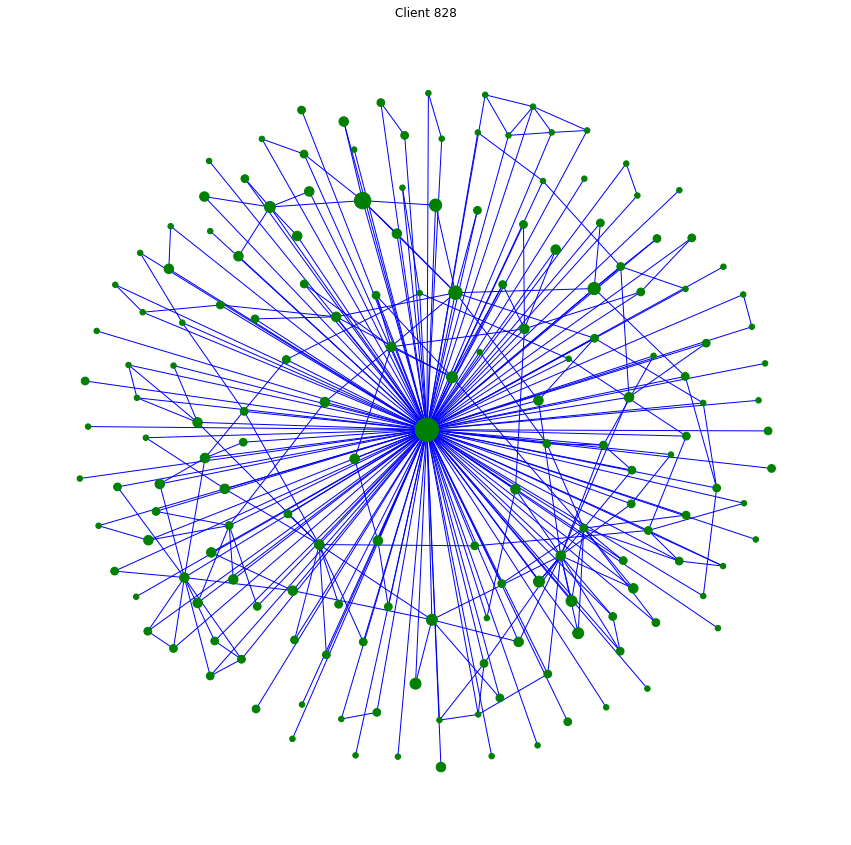

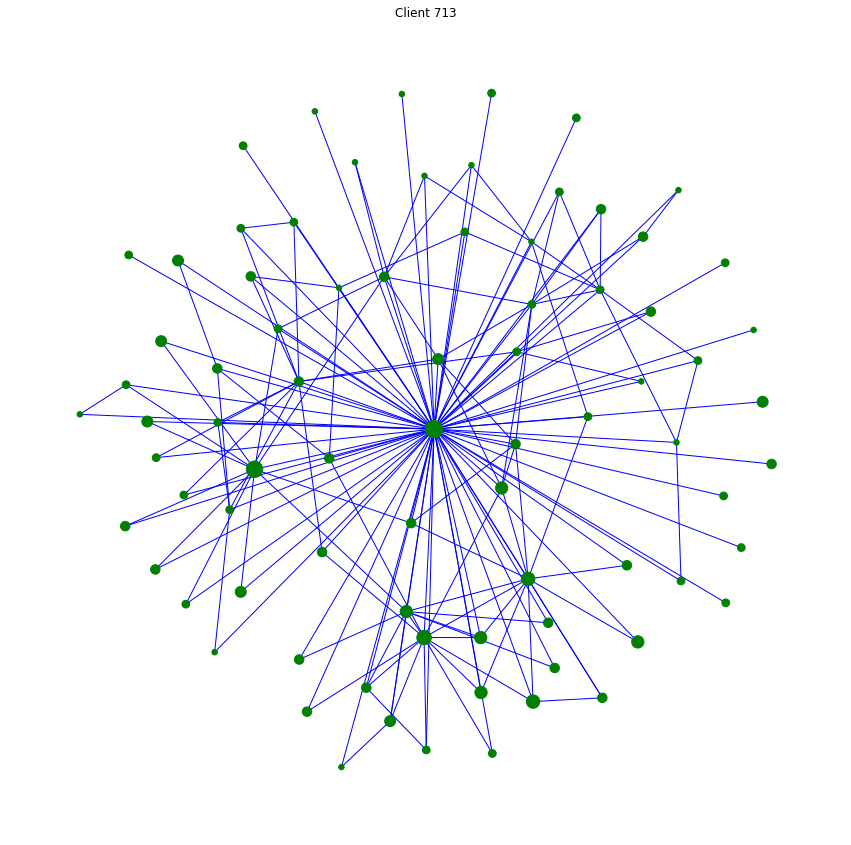

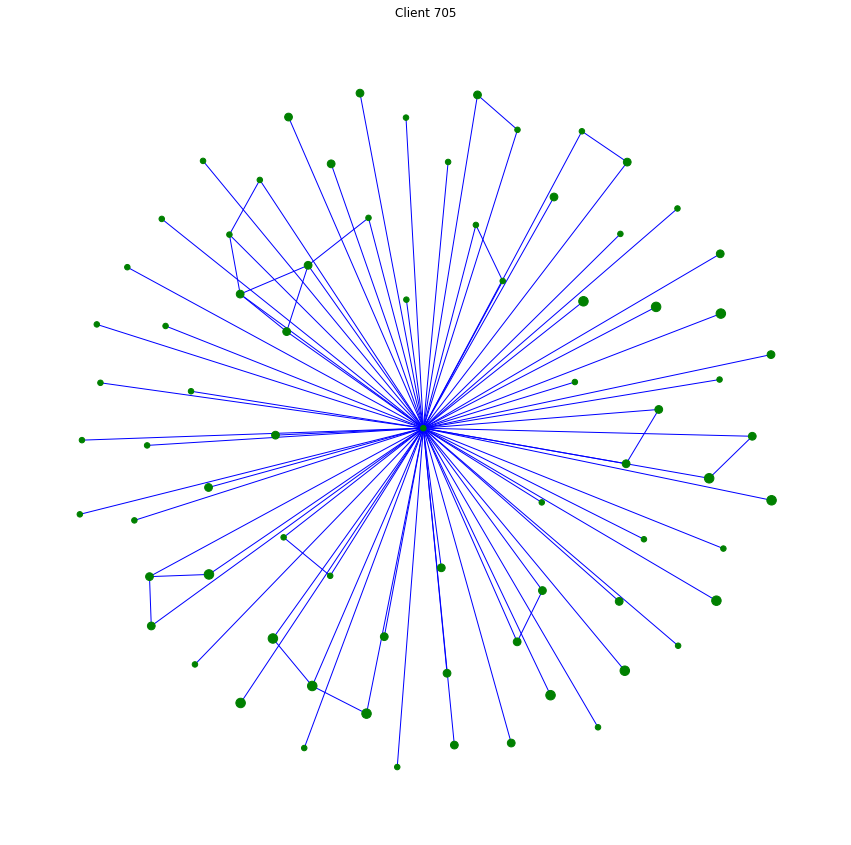

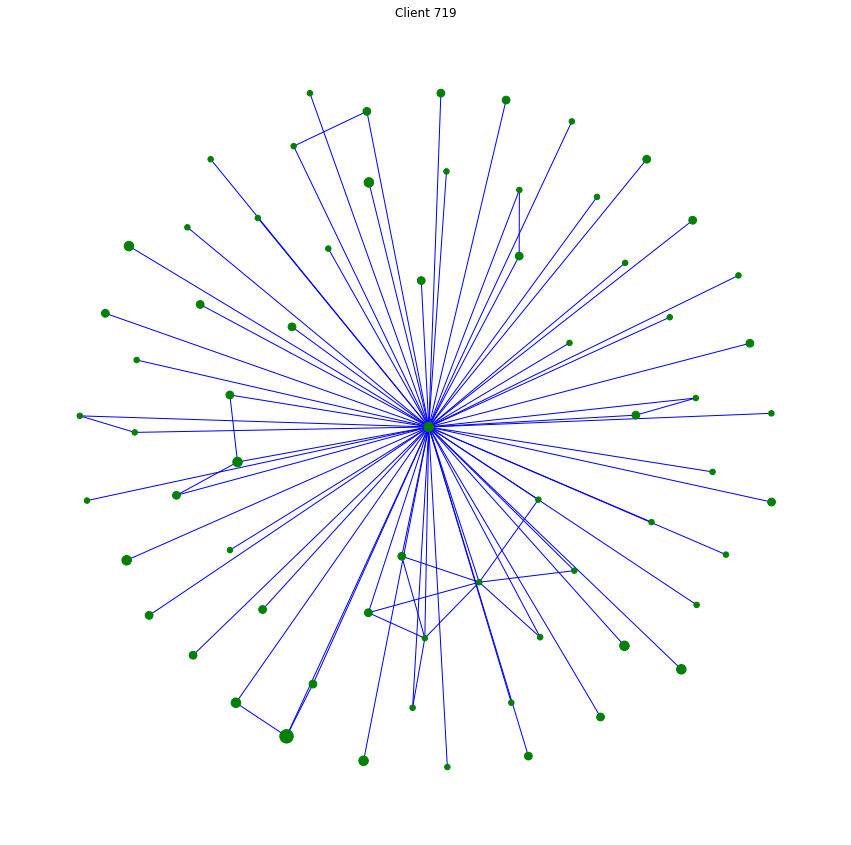

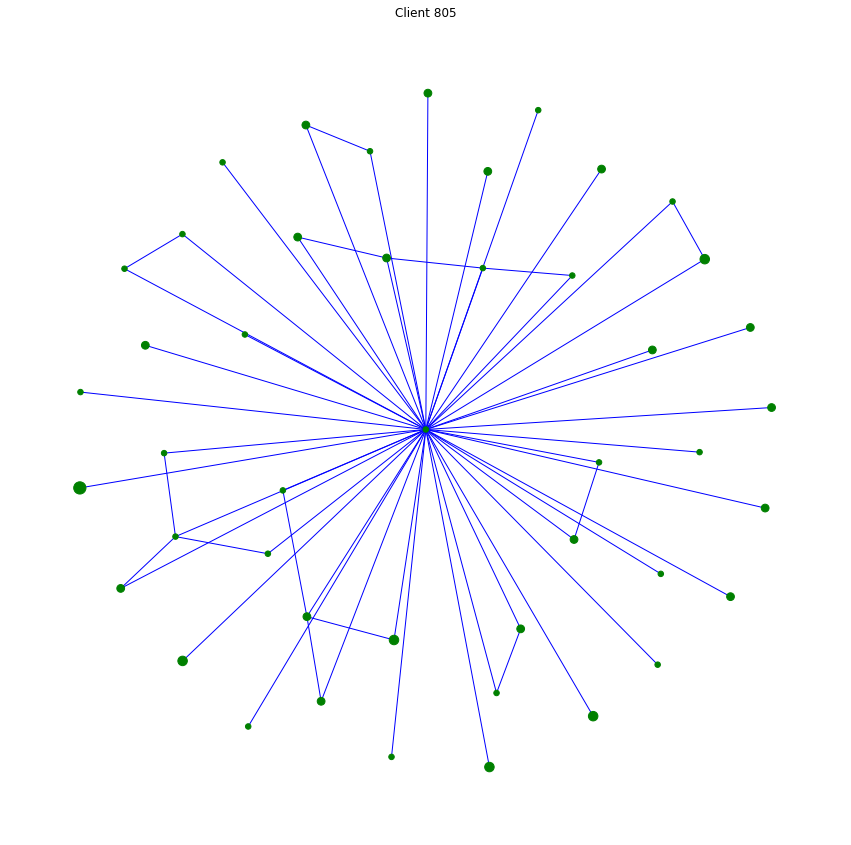

In [54]:
#plot the subgraphs with node size proportional to how many other subgraphs have that node in common
j = 0
for i in client_to_subgraph.keys():
    plt.figure(figsize=(15,15))
    plt.title('Client ' + str(i))
    nx.draw(client_to_subgraph[i], with_labels=False, node_size=[node_count[node]*30 for node in client_to_subgraph[i].nodes()], node_color='g', edge_color='b', font_size=10)
    plt.show()
    
    j += 1
    if j == 5:
        break
    

In [56]:
#list of nodes present in the entire cora graph
all_nodes = list(cora_graph.nodes())
nodes_in_subgraphs = node_count.keys()
nodes_not_in_subgraphs = []

#find the nodes that are not in any of the subgraphs
for node in all_nodes:
    if node not in nodes_in_subgraphs:
        nodes_not_in_subgraphs.append(node)
        
print(nodes_not_in_subgraphs)

[0, 1, 3, 4, 5, 7, 8, 9, 10, 12, 16, 17, 18, 19, 21, 23, 25, 26, 28, 31, 33, 35, 37, 39, 42, 44, 46, 47, 51, 54, 56, 57, 58, 62, 63, 64, 66, 67, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 92, 93, 96, 98, 99, 100, 104, 106, 107, 108, 110, 113, 114, 116, 117, 119, 120, 121, 122, 123, 125, 127, 128, 131, 132, 134, 135, 136, 137, 140, 144, 145, 147, 148, 161, 163, 164, 166, 167, 168, 169, 171, 177, 178, 182, 183, 184, 185, 186, 187, 190, 191, 192, 194, 197, 198, 199, 200, 202, 206, 207, 208, 209, 211, 212, 213, 214, 217, 220, 221, 222, 225, 227, 233, 234, 237, 238, 243, 245, 247, 248, 249, 250, 257, 259, 260, 262, 264, 266, 267, 269, 271, 272, 273, 275, 276, 278, 281, 282, 283, 284, 285, 286, 287, 288, 292, 293, 295, 296, 298, 299, 303, 307, 309, 311, 313, 315, 319, 320, 321, 322, 324, 325, 327, 328, 331, 332, 339, 340, 345, 349, 353, 354, 355, 356, 358, 360, 361, 363, 365, 368, 369, 370, 372, 374, 376, 378, 379, 380, 381, 385, 386, 390, 392, 393, 396, 397, 398, 399, 400, 404, 407, 410, 4

In [57]:
print(len(nodes_not_in_subgraphs))
print(len(nodes_in_subgraphs))

1386
1322


In [60]:
#training set is the nodes in the subgraphs
#create an empty list of size len(all_nodes)

train_mask = [False]*len(all_nodes)
for node in nodes_in_subgraphs:
    train_mask[node] = True
    
test_mask = [False]*len(all_nodes)
for node in nodes_not_in_subgraphs:
    test_mask[node] = True
    
train_x = all_data.x[train_mask]
train_y = all_data.y[train_mask]
    
test_x = all_data.x[test_mask]
test_y = all_data.y[test_mask]

print(test_x)

# #get the distribution of labels in the training set
# train_y_distribution = {}

# for i in range(len(train_y)):
#     if train_y[i].item() not in train_y_distribution:
#         train_y_distribution[train_y[i].item()] = 1
#     else:
#         train_y_distribution[train_y[i].item()] += 1
        
# print(train_y_distribution)

# #get the distribution of labels in the test set

# test_y_distribution = {}

# for i in range(len(test_y)):
#     if test_y[i].item() not in test_y_distribution:
#         test_y_distribution[test_y[i].item()] = 1
#     else:
#         test_y_distribution[test_y[i].item()] += 1
        
# print(test_y_distribution)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [61]:
test_x_node_ids = []
for i in range(len(test_mask)):
    if test_mask[i] == True:
        test_x_node_ids.append(i)
        
print(test_x_node_ids)

[0, 1, 3, 4, 5, 7, 8, 9, 10, 12, 16, 17, 18, 19, 21, 23, 25, 26, 28, 31, 33, 35, 37, 39, 42, 44, 46, 47, 51, 54, 56, 57, 58, 62, 63, 64, 66, 67, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 92, 93, 96, 98, 99, 100, 104, 106, 107, 108, 110, 113, 114, 116, 117, 119, 120, 121, 122, 123, 125, 127, 128, 131, 132, 134, 135, 136, 137, 140, 144, 145, 147, 148, 161, 163, 164, 166, 167, 168, 169, 171, 177, 178, 182, 183, 184, 185, 186, 187, 190, 191, 192, 194, 197, 198, 199, 200, 202, 206, 207, 208, 209, 211, 212, 213, 214, 217, 220, 221, 222, 225, 227, 233, 234, 237, 238, 243, 245, 247, 248, 249, 250, 257, 259, 260, 262, 264, 266, 267, 269, 271, 272, 273, 275, 276, 278, 281, 282, 283, 284, 285, 286, 287, 288, 292, 293, 295, 296, 298, 299, 303, 307, 309, 311, 313, 315, 319, 320, 321, 322, 324, 325, 327, 328, 331, 332, 339, 340, 345, 349, 353, 354, 355, 356, 358, 360, 361, 363, 365, 368, 369, 370, 372, 374, 376, 378, 379, 380, 381, 385, 386, 390, 392, 393, 396, 397, 398, 399, 400, 404, 407, 410, 4

In [62]:
print(len(test_x_node_ids))
print(len(test_x))
print(len(test_y))

1386
1386
1386


In [63]:
#get even distribution of data for test set
#maybe 100 nodes for each label

#initialize a dictionary of each label and a list of nodes with that label
label_to_nodes = {}

for i in range(len(test_y)):
    label = test_y[i].item()
    if label not in label_to_nodes:
        label_to_nodes[label] = [test_x_node_ids[i]]
    else:
        label_to_nodes[label].append(test_x_node_ids[i])

print(label_to_nodes)

{3: [0, 4, 7, 8, 17, 19, 21, 25, 44, 51, 57, 147, 167, 168, 169, 171, 178, 182, 183, 184, 185, 192, 197, 200, 207, 208, 212, 222, 237, 267, 269, 273, 278, 281, 285, 287, 288, 293, 295, 298, 309, 311, 313, 319, 321, 327, 332, 345, 374, 380, 386, 390, 396, 397, 398, 407, 411, 413, 418, 421, 432, 445, 453, 455, 457, 462, 469, 473, 477, 486, 500, 509, 518, 520, 546, 553, 555, 561, 570, 571, 575, 579, 592, 595, 599, 601, 605, 607, 618, 620, 622, 625, 639, 640, 641, 649, 653, 658, 662, 669, 670, 674, 690, 692, 695, 697, 700, 710, 713, 722, 727, 746, 768, 785, 788, 799, 811, 821, 827, 832, 833, 846, 855, 865, 866, 868, 879, 886, 900, 909, 914, 916, 920, 923, 926, 927, 928, 930, 932, 938, 942, 944, 952, 953, 959, 961, 967, 972, 974, 979, 981, 982, 986, 987, 988, 994, 997, 1000, 1005, 1014, 1016, 1017, 1019, 1024, 1031, 1044, 1048, 1053, 1055, 1056, 1057, 1059, 1065, 1066, 1073, 1080, 1084, 1086, 1091, 1092, 1096, 1098, 1099, 1101, 1106, 1108, 1116, 1124, 1126, 1130, 1132, 1134, 1151, 1159, 118

In [64]:
nodes_for_test_set = []

for label in label_to_nodes.keys():
    nodes_for_test_set += label_to_nodes[label][:100]
    
print(nodes_for_test_set)
print(len(nodes_for_test_set))


    

[0, 4, 7, 8, 17, 19, 21, 25, 44, 51, 57, 147, 167, 168, 169, 171, 178, 182, 183, 184, 185, 192, 197, 200, 207, 208, 212, 222, 237, 267, 269, 273, 278, 281, 285, 287, 288, 293, 295, 298, 309, 311, 313, 319, 321, 327, 332, 345, 374, 380, 386, 390, 396, 397, 398, 407, 411, 413, 418, 421, 432, 445, 453, 455, 457, 462, 469, 473, 477, 486, 500, 509, 518, 520, 546, 553, 555, 561, 570, 571, 575, 579, 592, 595, 599, 601, 605, 607, 618, 620, 622, 625, 639, 640, 641, 649, 653, 658, 662, 669, 1, 12, 33, 39, 63, 66, 75, 78, 82, 84, 140, 148, 166, 177, 187, 194, 198, 199, 209, 217, 243, 245, 247, 248, 250, 271, 275, 283, 284, 286, 299, 320, 325, 339, 340, 356, 361, 368, 369, 378, 381, 385, 420, 422, 431, 442, 450, 470, 488, 522, 529, 538, 545, 560, 582, 583, 585, 588, 602, 638, 652, 654, 665, 677, 714, 715, 740, 761, 774, 780, 782, 783, 786, 798, 802, 804, 808, 810, 813, 814, 854, 857, 893, 911, 922, 924, 943, 947, 949, 954, 956, 984, 1001, 1012, 1018, 1021, 1046, 1050, 1051, 1061, 3, 10, 35, 62, 79

In [66]:
#create test graph with the nodes in the test set

test_graph = nx.Graph()

for node in nodes_for_test_set:
    test_graph.add_node(node)
    
for node in nodes_for_test_set:
    for neighbor in neighbors[node]:
        if test_graph.has_node(neighbor):
            test_graph.add_edge(node, neighbor)

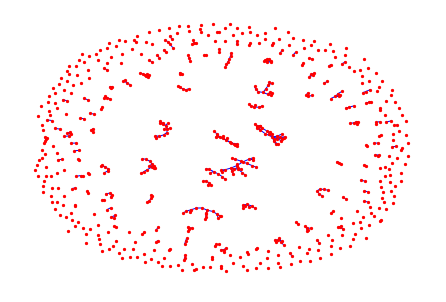

In [67]:
#plot the test graph
nx.draw(test_graph, with_labels=False, node_size=5, node_color='r', edge_color='b')
plt.show()


In [ ]:
#update 